# CNN for Image Classification of Multi-class Weather Dataset

This notebook is dedicated to the task of image classification, specifically focusing on categorizing images of various weather conditions. The dataset used for this purpose is the “Multi-class Weather Dataset for Image Classification” (Ajayi, Gbeminiyi, 2018, Mendeley Data, V1, doi: 10.17632/4drtyfjtfy.1).

The dataset consists of 1135 images with 4 different classes (cloudy, rain, shine, and sunrise). For the model training purpose, I will randomly split it with 80% in training and 20% for validation.

The primary tool for this task is PyTorch, with which a Convolutional Neural Network (CNN) model is implemented. The approach to the classification task include:
1. Constructing a CNN from the ground up.
2. Utilizing a pre-trained DenseNet121 model as a feature extractor.
3. Employing a pre-trained DenseNet121 model and fine-tuning it for our specific task.

Through these methods, we aim to explore and compare the effectiveness of different strategies in image classification tasks.

In [1]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils, models
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image

plt.rcParams.update({'axes.grid': False})

See if we could use GPU

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device.type}")

Using device: cuda


In [27]:
import torchvision

IMAGE_SIZE = (200, 200)

data_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()
])

# Loading the data
TRAIN_DIR = "../input/multiclass-weather-dataset/Multi-class Weather Dataset"
train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_DIR, transform=data_transforms)

# Define the split sizes for train and validation
train_size = int(0.8 * len(train_dataset)) 
val_size = len(train_dataset) - train_size  

# Split the dataset
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True, drop_last=True)

labels associated with the sample images:
tensor([2, 3, 3, 3, 1, 2, 2, 2, 0, 3, 2, 0, 2, 1, 1, 3, 2, 1, 1, 2, 3, 2, 1, 2,
        0, 0, 2, 0, 3, 0, 2, 0])


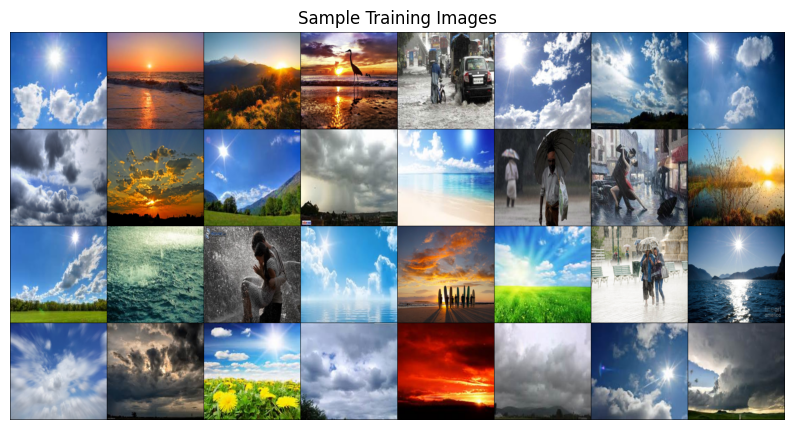

In [28]:
sample_batch = next(iter(train_loader))
plt.figure(figsize=(10, 8)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(sample_batch[0], padding=1, normalize=True), (1,2,0)))
print("labels associated with the sample images:")
print(sample_batch[1])

## A CNN model from scratch

In [29]:
def linear_block(input_size, output_size):
    return nn.Sequential(
        nn.Linear(input_size, output_size),
        nn.ReLU(),
        nn.Dropout(0.1)
    )

def conv_block(input_channels, output_channels):
    return torch.nn.Sequential(
        torch.nn.Conv2d(input_channels, output_channels, (5, 5), padding=1),
        torch.nn.ReLU(),
        nn.MaxPool2d((2, 2)),
        nn.Dropout(0.2)
    )

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            conv_block(3, 5),
            torch.nn.Flatten(),
            linear_block(49005, 1024),
            linear_block(1024, 64),
            nn.Linear(64, 4)
        )
        
    def forward(self, x):
        out = self.main(x)
        return out

In [32]:
def trainer(model, criterion, optimizer, trainloader, validloader, epochs=5, patience=5, verbose=True):
    """Simple training wrapper for PyTorch network."""
    
    train_loss = []
    valid_loss = []
    train_accuracy = []
    valid_accuracy = []
    consec_increases = 0
    
    for epoch in range(epochs):  # for each epoch
        
        train_batch_loss = 0
        train_batch_acc = 0
        valid_batch_loss = 0
        valid_batch_acc = 0
        
        # Training
        for X, y in trainloader:

            optimizer.zero_grad()                            # Zero all the gradients w.r.t. parameters
            X, y = X.to(device), y.to(device) 
            y_hat = model(X).squeeze()  # Forward pass to get output
            loss = criterion(y_hat, y.type(torch.long))   # Calculate loss based on output            
            loss.backward()                                  # Calculate gradients w.r.t. parameters
            optimizer.step()                                 # Update parameters

            train_batch_loss += loss.item()                  # Add loss for this batch to running total
            train_batch_acc += (y_hat.argmax(dim=1) == y).type(torch.float32).mean().item()    # Average accuracy for this batch
            
        train_loss.append(train_batch_loss / len(trainloader))     # loss = total loss in epoch / number of batches = loss per batch
        train_accuracy.append(train_batch_acc / len(trainloader))  # accuracy
        
        # Validation
        model.eval()  # this turns off those random dropout layers, we don't want them for validation!
        
        with torch.no_grad():  # this stops pytorch doing computational graph stuff under-the-hood and saves memory and time

            for X, y in validloader:                
                X, y = X.to(device), y.to(device) 
                y_hat = model(X).squeeze()
                loss = criterion(y_hat, y.type(torch.long))   # Calculate loss based on output

                valid_batch_loss += loss.item()                  # Add loss for this batch to running total
                valid_batch_acc += (y_hat.argmax(dim=1) == y).type(torch.float32).mean().item() # Average accuracy for this batch
                
        valid_loss.append(valid_batch_loss / len(validloader))
        valid_accuracy.append(valid_batch_acc / len(validloader))  # accuracy
        
        model.train()  # turn back on the dropout layers for the next training loop
        
        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1:3}:",
                  f"Train Loss: {train_loss[-1]:.3f}.",
                  f"Valid Loss: {valid_loss[-1]:.3f}.",
                  f"Train Accuracy: {train_accuracy[-1]:.2f}.",
                  f"Valid Accuracy: {valid_accuracy[-1]:.2f}.")
    
    results = {"train_loss": train_loss,
               "valid_loss": valid_loss,
               "train_accuracy": train_accuracy,
               "valid_accuracy": valid_accuracy}
    return results

In [34]:
torch.manual_seed(1)

model = CNN()
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

results = trainer(model, criterion, optimizer, train_loader, val_loader, epochs=50, patience=4)

Epoch   1: Train Loss: 1.404. Valid Loss: 0.943. Train Accuracy: 0.49. Valid Accuracy: 0.56.
Epoch   2: Train Loss: 0.688. Valid Loss: 0.678. Train Accuracy: 0.73. Valid Accuracy: 0.77.
Epoch   3: Train Loss: 0.541. Valid Loss: 0.666. Train Accuracy: 0.78. Valid Accuracy: 0.77.
Epoch   4: Train Loss: 0.451. Valid Loss: 0.620. Train Accuracy: 0.85. Valid Accuracy: 0.79.
Epoch   5: Train Loss: 0.361. Valid Loss: 0.615. Train Accuracy: 0.88. Valid Accuracy: 0.81.
Epoch   6: Train Loss: 0.274. Valid Loss: 0.572. Train Accuracy: 0.91. Valid Accuracy: 0.82.
Epoch   7: Train Loss: 0.247. Valid Loss: 0.739. Train Accuracy: 0.92. Valid Accuracy: 0.80.
Epoch   8: Train Loss: 0.317. Valid Loss: 0.691. Train Accuracy: 0.88. Valid Accuracy: 0.82.
Epoch   9: Train Loss: 0.190. Valid Loss: 0.770. Train Accuracy: 0.93. Valid Accuracy: 0.81.
Epoch  10: Train Loss: 0.171. Valid Loss: 0.698. Train Accuracy: 0.94. Valid Accuracy: 0.80.
Epoch  11: Train Loss: 0.163. Valid Loss: 0.682. Train Accuracy: 0.94.

In [35]:
import plotly.graph_objects as go

def plot_loss(train_loss, valid_loss, train_accuracy, valid_accuracy):
    epochs = list(range(1, len(train_loss) + 1))

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=epochs, y=train_loss, mode='lines', name='Training Loss'))
    fig.add_trace(go.Scatter(x=epochs, y=valid_loss, mode='lines', name='Validation Loss'))
    fig.update_layout(title='Training and Validation Loss', xaxis_title='Epochs', yaxis_title='Loss')
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=epochs, y=train_accuracy, mode='lines', name='Training Accuracy'))
    fig.add_trace(go.Scatter(x=epochs, y=valid_accuracy, mode='lines', name='Validation Accuracy'))
    fig.update_layout(title='Training and Validation Accuracy', xaxis_title='Epochs', yaxis_title='Accuracy')
    fig.show()


In [36]:
plot_loss(results["train_loss"], results["valid_loss"], results["train_accuracy"], results["valid_accuracy"])

### Showing the prediction of an image in validation set

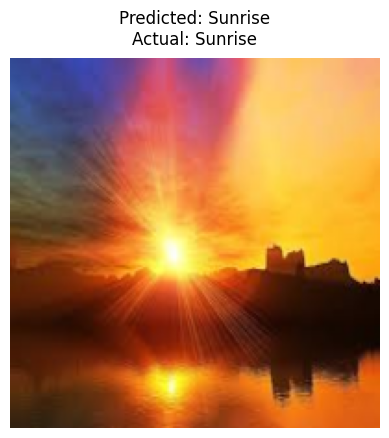

In [52]:
model.eval()
model.to('cpu')
class_names = ['Cloudy', 'Rain', 'Shine', 'Sunrise']  # replace with your actual class names

with torch.no_grad():
    img, label = next(iter(val_loader))
    img = img[0].to('cpu')
    label = label[0].to('cpu')
    
    y_hat = model(img[None, :, :, :])
    _, predicted = torch.max(y_hat, 1)
    
    plt.imshow(img.permute(1, 2, 0))
    plt.axis("off")
    plt.title(f"Predicted: {class_names[predicted.item()]}\nActual: {class_names[label.item()]}", pad=10)
    plt.show()

We have achieved a 0.86 validation accuracy with a model built from scratch, which is a pretty good start!

## Transfer Learning

Here we are leveraging a pre-trained DenseNet121 model for a classification task (https://arxiv.org/abs/1608.06993). To adapt it to this problem, I freeze the original model’s parameters to prevent them from being updated during training. Then, I replace the classifier of the DenseNet model with a new sequential model and it will be trained on the training data.

In [53]:
densenet = models.densenet121(weights='DenseNet121_Weights.DEFAULT')

for param in densenet.parameters():  # Freeze parameters so we don't update them
    param.requires_grad = False

new_layers = nn.Sequential(
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 4)
)
densenet.classifier = new_layers

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 126MB/s] 


In [54]:
densenet.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(densenet.parameters(), lr=0.001)
results = trainer(densenet, criterion, optimizer, train_loader, val_loader, epochs=50)

Epoch   1: Train Loss: 0.663. Valid Loss: 0.392. Train Accuracy: 0.75. Valid Accuracy: 0.85.
Epoch   2: Train Loss: 0.182. Valid Loss: 0.202. Train Accuracy: 0.95. Valid Accuracy: 0.92.
Epoch   3: Train Loss: 0.155. Valid Loss: 0.265. Train Accuracy: 0.95. Valid Accuracy: 0.91.
Epoch   4: Train Loss: 0.097. Valid Loss: 0.211. Train Accuracy: 0.97. Valid Accuracy: 0.92.
Epoch   5: Train Loss: 0.095. Valid Loss: 0.162. Train Accuracy: 0.97. Valid Accuracy: 0.94.
Epoch   6: Train Loss: 0.062. Valid Loss: 0.160. Train Accuracy: 0.98. Valid Accuracy: 0.94.
Epoch   7: Train Loss: 0.067. Valid Loss: 0.248. Train Accuracy: 0.98. Valid Accuracy: 0.93.
Epoch   8: Train Loss: 0.101. Valid Loss: 0.162. Train Accuracy: 0.97. Valid Accuracy: 0.95.
Epoch   9: Train Loss: 0.075. Valid Loss: 0.186. Train Accuracy: 0.97. Valid Accuracy: 0.94.
Epoch  10: Train Loss: 0.038. Valid Loss: 0.177. Train Accuracy: 0.99. Valid Accuracy: 0.95.
Epoch  11: Train Loss: 0.022. Valid Loss: 0.181. Train Accuracy: 0.99.

In [55]:
plot_loss(results["train_loss"], results["valid_loss"], results["train_accuracy"], results["valid_accuracy"])

### Showing the prediction of an image in validation set

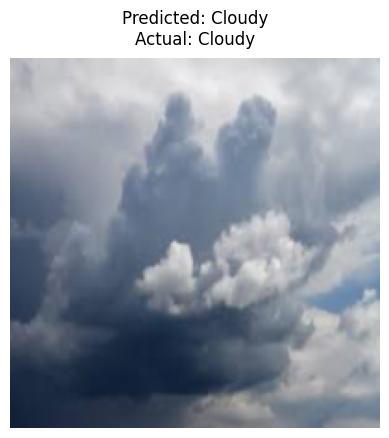

In [56]:
model.eval()
model.to('cpu')
class_names = ['Cloudy', 'Rain', 'Shine', 'Sunrise']  # replace with your actual class names

with torch.no_grad():
    img, label = next(iter(val_loader))
    img = img[0].to('cpu')
    label = label[0].to('cpu')
    
    y_hat = model(img[None, :, :, :])
    _, predicted = torch.max(y_hat, 1)
    
    plt.imshow(img.permute(1, 2, 0))
    plt.axis("off")
    plt.title(f"Predicted: {class_names[predicted.item()]}\nActual: {class_names[label.item()]}", pad=10)
    plt.show()

Here, we could achieve a 96% accuracy in validation leveraging the power of pre-trained model.

# Fine tuning a pre-trained Densenet Model

In below, I’m adapting a pre-trained DenseNet121 model to a specific classification task by freezing most of its layers (except for the last three) and replacing the classifier with a new one. This approach allows us to leverage the powerful feature extraction capabilities of DenseNet121 while training a custom classifier for this specific task.

In [57]:
densenet = models.densenet121(weights='DenseNet121_Weights.DEFAULT')
for layer in densenet.features[:-3]:
    for param in layer.parameters():
        param.requires_grad = False
        
new_layers = nn.Sequential(
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 4)
)
densenet.classifier = new_layers

In [58]:
densenet.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(densenet.parameters(), lr=0.001)
results = trainer(densenet, criterion, optimizer, train_loader, val_loader, epochs=50)

Epoch   1: Train Loss: 0.262. Valid Loss: 0.243. Train Accuracy: 0.91. Valid Accuracy: 0.94.
Epoch   2: Train Loss: 0.052. Valid Loss: 0.329. Train Accuracy: 0.98. Valid Accuracy: 0.92.
Epoch   3: Train Loss: 0.071. Valid Loss: 0.171. Train Accuracy: 0.97. Valid Accuracy: 0.96.
Epoch   4: Train Loss: 0.043. Valid Loss: 0.260. Train Accuracy: 0.98. Valid Accuracy: 0.97.
Epoch   5: Train Loss: 0.020. Valid Loss: 0.225. Train Accuracy: 0.99. Valid Accuracy: 0.96.
Epoch   6: Train Loss: 0.054. Valid Loss: 0.344. Train Accuracy: 0.99. Valid Accuracy: 0.96.
Epoch   7: Train Loss: 0.021. Valid Loss: 0.309. Train Accuracy: 0.99. Valid Accuracy: 0.96.
Epoch   8: Train Loss: 0.018. Valid Loss: 0.178. Train Accuracy: 1.00. Valid Accuracy: 0.96.
Epoch   9: Train Loss: 0.053. Valid Loss: 0.329. Train Accuracy: 0.98. Valid Accuracy: 0.94.
Epoch  10: Train Loss: 0.025. Valid Loss: 0.316. Train Accuracy: 0.99. Valid Accuracy: 0.96.
Epoch  11: Train Loss: 0.017. Valid Loss: 0.258. Train Accuracy: 0.99.

In [59]:
plot_loss(results["train_loss"], results["valid_loss"], results["train_accuracy"], results["valid_accuracy"])

We have achieved a even slightly higher accuracy of 0.97 here.